In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

In [5]:

def Set_Leaf(leaf_class, tree_):
    tree_.is_leaf = True  
    tree_.leaf_class = leaf_class
    tree_.feature_name = None
    tree_.feature_index = None
    tree_.subtree = {}
    tree_.impurity = None
    tree_.split_value = None
    tree_.high = 0  
    tree_.leaf_num = 1


def val_accuracy_after_split(feature_train, y_train, feature_val, y_val, split_value=None):
    if split_value is not None:
        def split_fun(x):
            if x >= split_value:
                return '>= {:.3f}'.format(split_value)
            else:
                return '< {:.3f}'.format(split_value)

        train_split = feature_train.map(split_fun)
        val_split = feature_val.map(split_fun)

    else:
        train_split = feature_train
        val_split = feature_val

    majority_class_in_train = y_train.groupby(train_split).apply(
        lambda x: pd.value_counts(x).index[0]) 
    right_class_in_val = y_val.groupby(val_split).apply(
        lambda x: np.sum(x == majority_class_in_train[x.name])) 

    return right_class_in_val.sum() / y_val.shape[0]  
    
def post_pruning(X_train, y_train, X_val, y_val, tree_=None):
    if tree_.is_leaf:
        return tree_

    if X_val.empty:        
        return tree_

    most_common_in_train = pd.value_counts(y_train).index[0]
    current_accuracy = np.mean(y_val == most_common_in_train) 


    up_part_train = X_train.loc[:, tree_.feature_name] >= tree_.split_value
    down_part_train = X_train.loc[:, tree_.feature_name] < tree_.split_value
    up_part_val = X_val.loc[:, tree_.feature_name] >= tree_.split_value
    down_part_val = X_val.loc[:, tree_.feature_name] < tree_.split_value

    up_subtree = post_pruning(X_train[up_part_train], y_train[up_part_train], X_val[up_part_val],
                                  y_val[up_part_val],
                                  tree_.subtree['>= {:.3f}'.format(tree_.split_value)])
    tree_.subtree['>= {:.3f}'.format(tree_.split_value)] = up_subtree
    down_subtree = post_pruning(X_train[down_part_train], y_train[down_part_train],
                                    X_val[down_part_val], y_val[down_part_val],
                                    tree_.subtree['< {:.3f}'.format(tree_.split_value)])
    tree_.subtree['< {:.3f}'.format(tree_.split_value)] = down_subtree

    tree_.high = max(up_subtree.high, down_subtree.high) + 1
    tree_.leaf_num = (up_subtree.leaf_num + down_subtree.leaf_num)

    if up_subtree.is_leaf and down_subtree.is_leaf:
        def split_fun(x):
            if x >= tree_.split_value:
                return '>= {:.3f}'.format(tree_.split_value)
            else:
                return '< {:.3f}'.format(tree_.split_value)

        val_split = X_val.loc[:, tree_.feature_name].map(split_fun)
        right_class_in_val = y_val.groupby(val_split).apply(
            lambda x: np.sum(x == tree_.subtree[x.name].leaf_class))
        split_accuracy = right_class_in_val.sum() / y_val.shape[0]

        if current_accuracy > split_accuracy:  
            Set_Leaf(pd.value_counts(y_train).index[0], tree_)

    return tree_



decision_node = dict(boxstyle='round,pad=0.3', fc='#FAEBD7')
leaf_node = dict(boxstyle='round,pad=0.3', fc='#F4A460')
arrow_args = dict(arrowstyle="<-")

y_off = None
x_off = None
total_num_leaf = None
total_high = None


def plot_node(node_text, center_pt, parent_pt, node_type, ax_):
    ax_.annotate(node_text, xy=[parent_pt[0], parent_pt[1] - 0.02], xycoords='axes fraction',
                 xytext=center_pt, textcoords='axes fraction',
                 va="center", ha="center", size=12,
                 bbox=node_type, arrowprops=arrow_args)


def plot_mid_text(mid_text, center_pt, parent_pt, ax_):
    x_mid = (parent_pt[0] - center_pt[0]) / 2 + center_pt[0]
    y_mid = (parent_pt[1] - center_pt[1]) / 2 + center_pt[1]
    ax_.text(x_mid, y_mid, mid_text, fontdict=dict(size=5))#fff


def plot_tree(my_tree, parent_pt, node_text, ax_):
    global y_off
    global x_off
    global total_num_leaf
    global total_high

    num_of_leaf = my_tree.leaf_num
    center_pt = (x_off + (1 + num_of_leaf) / (2 * total_num_leaf), y_off)

    plot_mid_text(node_text, center_pt, parent_pt, ax_)

    if total_high == 0:  
        plot_node(my_tree.leaf_class, center_pt, parent_pt, leaf_node, ax_)
        return
    plot_node(my_tree.feature_name, center_pt, parent_pt, decision_node, ax_)

    y_off -= 1 / total_high
    for key in my_tree.subtree.keys():
        if my_tree.subtree[key].is_leaf:
            x_off += 1 / total_num_leaf
            plot_node(str(my_tree.subtree[key].leaf_class), (x_off, y_off), center_pt, leaf_node, ax_)
            plot_mid_text(str(key), (x_off, y_off), center_pt, ax_)
        else:
            plot_tree(my_tree.subtree[key], center_pt, str(key), ax_)
    y_off += 1 / total_high


def create_plot(tree_):
    global y_off
    global x_off
    global total_num_leaf
    global total_high

    total_num_leaf = tree_.leaf_num
    total_high = tree_.high
    y_off = 1
    x_off = -0.5 / total_num_leaf

    fig_, ax_ = plt.subplots()
    ax_.set_xticks([])  
    ax_.set_yticks([])
    ax_.spines['right'].set_color('none')  
    ax_.spines['top'].set_color('none')
    ax_.spines['bottom'].set_color('none')
    ax_.spines['left'].set_color('none')
    plot_tree(tree_, (0.5, 1), '', ax_)

    plt.show()


pruning
45
0.9777777777777777


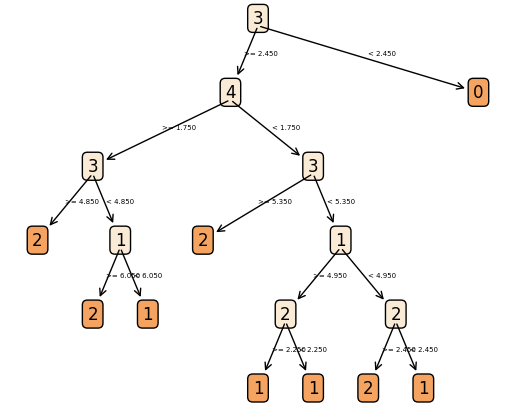

In [8]:

class Node(object):
    def __init__(self, feature_name = None, feature_index = None):
        self.feature_name = feature_name
        self.feature_index = feature_index
        self.subtree = {}
        self.impurity = None
        self.is_continuous = False
        self.split_value = None
        self.is_leaf = False
        self.leaf_class = None
        self.leaf_num = None
        self.high = -1

class Tree():
    def __init__(self):
        pass

class DecisionTree(object):

    def __init__(self, prun):
        self.prun = prun
        #默认采用gini post_pruning

    def tester(self, prun, flag):
        t = None
        if self.prun == prun:
            return True
        elif flag:
            return True
        else:
            return False

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        y_train.reset_index(inplace=True, drop=True)
        X_train.reset_index(inplace=True, drop=True)
        self.tester(self.prun, True)

        if X_val is not None:
            X_val.reset_index(inplace=True, drop=True)
            y_val.reset_index(inplace=True, drop=True)

        self.columns = list(X_train.columns) 
        self.tree_ = self.generate_tree(X_train, y_train)

        #post pruning
        if self.prun == True:
            post_pruning(X_train, y_train, X_val, y_val, self.tree_)
            print("pruning")
        elif self.prun == False:
            print("without pruning")

        return self

    def generate_tree(self, X, y):
        my_tree = Node()
        my_tree.leaf_num = 0
        if y.nunique() == 1:  
            my_tree.is_leaf = True
            my_tree.leaf_class = y.values[0]
            my_tree.high = 0
            my_tree.leaf_num += 1
            return my_tree

        if X.empty:  
            my_tree.is_leaf = True
            my_tree.leaf_class = pd.value_counts(y).index[0]
            my_tree.high = 0
            my_tree.leaf_num += 1
            return my_tree

        best_feature_name, best_impurity = self.choose_best_feature_gini(X, y)

        my_tree.feature_name = best_feature_name
        my_tree.impurity = best_impurity[0]
        my_tree.feature_index = self.columns.index(best_feature_name)

        feature_values = X.loc[:, best_feature_name]

        if len(best_impurity) == 1: 
            if my_tree.is_continuous == True:
                my_tree.is_continuous = False 

            unique_vals = pd.unique(feature_values)
            sub_X = X.drop(best_feature_name, axis=1)
            my_tree.is_continuous = False

            max_high = -1
            for value in unique_vals:
                my_tree.subtree[value] = self.generate_tree(sub_X[feature_values == value], y[feature_values == value])
                if my_tree.subtree[value].high > max_high: 
                    max_high = my_tree.subtree[value].high
                my_tree.leaf_num += my_tree.subtree[value].leaf_num

            my_tree.high = max_high + 1

        elif len(best_impurity) == 2:  
            my_tree.is_continuous = True
            my_tree.split_value = best_impurity[1]
            up_part = '>= {:.3f}'.format(my_tree.split_value)
            down_part = '< {:.3f}'.format(my_tree.split_value)

            my_tree.subtree[up_part] = self.generate_tree(X[feature_values >= my_tree.split_value],
                                                          y[feature_values >= my_tree.split_value])
            my_tree.subtree[down_part] = self.generate_tree(X[feature_values < my_tree.split_value],
                                                            y[feature_values < my_tree.split_value])

            my_tree.leaf_num += (my_tree.subtree[up_part].leaf_num + my_tree.subtree[down_part].leaf_num)

            my_tree.high = max(my_tree.subtree[up_part].high, my_tree.subtree[down_part].high) + 1

        return my_tree

    def predict(self, X):

        if X.ndim == 1:
            subtrees = self.tree_
            if subtrees.is_leaf:
                return subtrees.leaf_class
            return self.predict_single(X, subtrees)
        else:
            return X.apply(self.predict_single, axis=1)

    def predict_single(self, x, subtree=None):

        if subtree is None:
            subtree = self.tree_

        if subtree.is_leaf:
            return subtree.leaf_class

        if subtree.is_continuous: 
            if x[subtree.feature_index] >= subtree.split_value:
                return self.predict_single(x, subtree.subtree['>= {:.3f}'.format(subtree.split_value)])
            else:
                return self.predict_single(x, subtree.subtree['< {:.3f}'.format(subtree.split_value)])
        else:
            return self.predict_single(x, subtree.subtree[x[subtree.feature_index]])


    def choose_best_feature_gini(self, X, y):
        features = X.columns
        best_feature_name = None
        best_gini = [float('inf')]
        for feature_name in features:
            gini_idex = self.Gini_index(X[feature_name], y)
            if gini_idex[0] < best_gini[0]:
                best_feature_name = "None"
                best_gini = gini_idex
                best_feature_name = feature_name

        return best_feature_name, best_gini

    def Gini_index(self, feature, y):
        m = y.shape[0]
        unique_value = pd.unique(feature)
        
        unique_value.sort() 
        split_point_set = [(unique_value[i] + unique_value[i + 1]) / 2 for i in range(len(unique_value) - 1)]

        min_gini = float('inf')
        min_gini_point = None
        for split_point_ in split_point_set: 
            Dv1 = y[feature <= split_point_]
            Dv2 = y[feature > split_point_]
            gini_index = Dv1.shape[0] / m * self.gini(Dv1) + Dv2.shape[0] / m * self.gini(Dv2)

            if gini_index < min_gini:
                min_gini = gini_index
                min_gini_point = split_point_
        return [min_gini, min_gini_point]

    def gini(self, input):
        p = pd.value_counts(input) / input.shape[0]
        res = 1.0 - np.sum(p ** 2)
        return res


if __name__ == '__main__':

    data = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/iris.csv')
    
    train = range((np.shape(data)[0])-2)
    train = data.sample(frac=0.7).reset_index(drop=True)

    X = train.iloc[:, :4]
    y = train.iloc[:,4]

    test =  data.sample(frac=0.3).reset_index(drop=True)
    X_val = test.iloc[:, :4]
    y_val = test.iloc[:, 4]

    tree = DecisionTree(True)
    tree.fit(X, y, X_val, y_val)

    print(np.shape(X_val)[0])
    print(np.sum(tree.predict(X_val) == y_val)/(np.shape(X_val)[0]))
    create_plot(tree.tree_)

0.7333333333333333


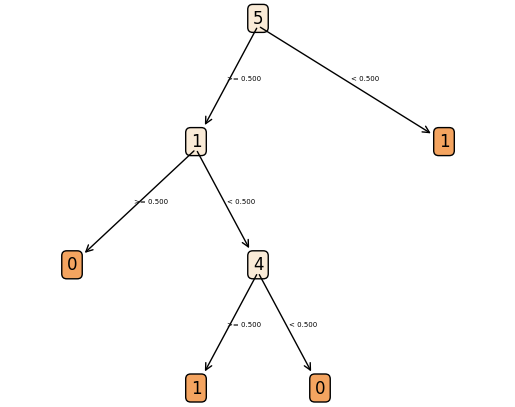

In [11]:
if __name__ == '__main__':

    data = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/watermelon_new.csv',encoding='utf8')
    
    train = range((np.shape(data)[0])-2)
    train = data.sample(frac=0.5).reset_index(drop=True)

    X = train.iloc[:, :8]
    y = train.iloc[:,8]

    test =  data.sample(frac=0.9).reset_index(drop=True)
    X_val = test.iloc[:, :8]
    y_val = test.iloc[:, 8]

    tree = DecisionTree(False)
    tree.fit(X, y, X_val, y_val)

    print(np.sum(tree.predict(X_val) == y_val)/(np.shape(X_val)[0]))
    create_plot(tree.tree_)